In [ ]:
%cd '/content/drive/MyDrive/Colab Notebooks/football'

/content/drive/MyDrive/Colab Notebooks/football


In [ ]:
# importing the libraries
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
from time import time
from torchvision import datasets, transforms
from torch import nn, optim
import cv2

In [ ]:
# version of pytorch
print(torch.__version__)

1.8.1+cu101


In [ ]:
# transformations to be applied on images
transform = transforms.Compose([
                                transforms.Resize((32,32)),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                              ])

In [ ]:
# define dataset
trainData = torchvision.datasets.ImageFolder('./team_dataset/train', transform=transform)
testData  = torchvision.datasets.ImageFolder('./team_dataset/test',  transform=transform)

# defining trainloader and testloader
trainloader = torch.utils.data.DataLoader(trainData, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(testData, batch_size=64, shuffle=True)

In [ ]:
# shape of training data
dataiter = iter(trainloader)
images, labels = dataiter.next()

print(f'tensor shape  : {images.shape}   labels shape : {labels.shape}')

tensor shape  : torch.Size([64, 3, 32, 32])   labels shape : torch.Size([64])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


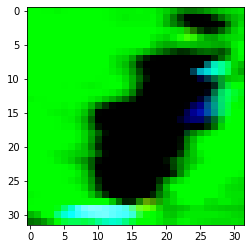

In [ ]:
# visualizing the training images
npimg = images[0].numpy()
plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')

In [ ]:
# defining the model architecture
class Net(nn.Module):   
  def __init__(self):
      super(Net, self).__init__()

      self.cnn_layers = nn.Sequential(
          # Defining a 2D convolution layer
          nn.Conv2d(3, 4, kernel_size=3, stride=1, padding=1),
          nn.BatchNorm2d(4),
          nn.ReLU(inplace=True),
          nn.MaxPool2d(kernel_size=2, stride=2),
          # Defining another 2D convolution layer
          nn.Conv2d(4, 4, kernel_size=3, stride=1, padding=1),
          nn.BatchNorm2d(4),
          nn.ReLU(inplace=True),
          nn.MaxPool2d(kernel_size=2, stride=2),
      )

      self.linear_layers = nn.Sequential(
          nn.Linear(4 * 8 * 8, 3)
      )

  # Defining the forward pass    
  def forward(self, x):
      x = self.cnn_layers(x)
      x = x.view(x.size(0), -1)
      x = self.linear_layers(x)
      return x

In [ ]:
# defining the model
model = Net()
# defining the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.01)
# defining the loss function
criterion = nn.CrossEntropyLoss()
# checking if GPU is available
if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()
    
print(model)

Net(
  (cnn_layers): Sequential(
    (0): Conv2d(3, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear_layers): Sequential(
    (0): Linear(in_features=256, out_features=3, bias=True)
  )
)


In [ ]:
for i in range(15):
    running_loss = 0
    for images, labels in trainloader:

        if torch.cuda.is_available():
          images = images.cuda()
          labels = labels.cuda()

        # Training pass
        optimizer.zero_grad()
        output = model(images)
        loss = criterion(output, labels)
        
        #This is where the model learns by backpropagating
        loss.backward()
        
        #And optimizes its weights here
        optimizer.step()
        
        running_loss += loss.item()
    else:
        print("Epoch {} - Training loss: {}".format(i+1, running_loss/len(trainloader)))

Epoch 1 - Training loss: 0.776624184846878
Epoch 2 - Training loss: 0.1580103799700737
Epoch 3 - Training loss: 0.031336510181427
Epoch 4 - Training loss: 0.012588993646204472
Epoch 5 - Training loss: 0.004356989450752735
Epoch 6 - Training loss: 0.0028171444311738012
Epoch 7 - Training loss: 0.0022559971548616886
Epoch 8 - Training loss: 0.0013768545235507191
Epoch 9 - Training loss: 0.0011164828087203205
Epoch 10 - Training loss: 0.0007999803114216774
Epoch 11 - Training loss: 0.00070559938903898
Epoch 12 - Training loss: 0.0005358370370231568
Epoch 13 - Training loss: 0.0005326573766069487
Epoch 14 - Training loss: 0.0006989357993006706
Epoch 15 - Training loss: 0.00041632394422777


In [ ]:
# getting predictions on test set and measuring the performance
correct_count, all_count = 0, 0
for images,labels in testloader:
  for i in range(len(labels)):
    if torch.cuda.is_available():
        images = images.cuda()
        labels = labels.cuda()
    img = images[i].view(1, 3, 32, 32)
    with torch.no_grad():
        logps = model(img)

    
    ps = torch.exp(logps)
    probab = list(ps.cpu()[0])
    pred_label = probab.index(max(probab))
    true_label = labels.cpu()[i]
    if(true_label == pred_label):
      correct_count += 1
    all_count += 1

print("Number Of Images Tested =", all_count)
print("\nModel Accuracy =", (correct_count/all_count))

Number Of Images Tested = 31

Model Accuracy = 0.8387096774193549


In [ ]:
torch.save(model.state_dict(), './teamCategoryModel.pth')